# Fitting DLT with Complex Seasonality - Daily Forecast Example

There are some challenges to fit complex seasonality with LGT/DLT. Although one should usually look into some models such as **Kernel-based Time-varying Regression(KTR)** from other section, we demonstrate a work around if one wants explore complex seasonality model with DLT.

## the data

Daily forecast is one of most popular use cases in time-series modeling. In this example, it aims to introduce a way to perform a daily forecast by modeling yearly and weekly seasonality together in **DLT**. We will use the aggregated number of sales from the [M5 competition](https://www.kaggle.com/c/m5-forecasting-accuracy/overview) and Turkish daily electricity demand data from Rob Hyndman's [post](https://robjhyndman.com/publications/complex-seasonality/)

In [1]:
import pandas as pd
import numpy as np
import ssl 

from orbit.models import DLT
from orbit.diagnostics.plot import plot_predicted_data
# to make fourier series for annual seasonality
from orbit.utils.features import make_fourier_series_df
from orbit.utils.dataset import load_electricity_demand, load_m5daily
from orbit.utils.params_tuning import generate_param_args_list

%load_ext autoreload
%autoreload 2

## the methodology

Here user can leverage Fourier terms as regressors to handle extra layers of seasonality while using **DLT** seasonality argument for the first layer (the one with the shortest cycle). This type of regression is also referred to **harmonic regression** by Young, Pedregal & Tych(1999).

## Example I - M5 Aggregated Sales

For demo purpose, we just use a subset of regressors and perform log transformation on response to construct a multiplicative model.

In [2]:
df = load_m5daily()
# get a subset of regressor for demo purpose
regressor_col = ["Christmas","Halloween","LaborDay","Thanksgiving","Mother's day","PresidentsDay","NewYear"]

Users can use the `make_fourier_series_df` to create Fourier terms. A `log` and division by first observation also used as pre-processing to make a better fit.

In [3]:
df, fs_cols = make_fourier_series_df(df, period=365.25, order=3)
# trim data with useful columns only
df = df[["date", "sales"] + fs_cols + regressor_col]
m = df['sales'][0]
df['y'] = np.log(df['sales']/m)

In [4]:
test_size = 28
train_df = df[:-test_size]
test_df = df[-test_size:]

In [5]:
train_df.head(5)

,date,sales,fs_cos1,fs_sin1,fs_cos2,fs_sin2,fs_cos3,fs_sin3,Christmas,Halloween,LaborDay,Thanksgiving,Mother's day,PresidentsDay,NewYear,y
0,2011-01-29,32631,0.999852,0.017202,0.999408,0.034398,0.998669,0.051584,0,0,0,0,0,0,0,0.000000
1,2011-01-30,31749,0.999408,0.034398,0.997634,0.068755,0.994678,0.103031,0,0,0,0,0,0,0,-0.027402
2,2011-01-31,23783,0.998669,0.051584,0.994678,0.103031,0.988039,0.154204,0,0,0,0,0,0,0,-0.316292
3,2011-02-01,25412,0.997634,0.068755,0.990545,0.137185,0.978769,0.204966,0,0,0,0,0,0,0,-0.250041
4,2011-02-02,19146,0.996303,0.085906,0.985240,0.171177,0.966893,0.255182,0,0,0,0,0,0,0,-0.533169


initialize and train the model.

In [6]:
%%time
dlt = DLT(
    response_col='y',
    date_col='date',
    seasonality=7,
    seed=2020,
    regressor_col=fs_cols + regressor_col,
    estimator='stan-mcmc',
)
dlt.fit(train_df)

INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
To run all diagnostics call pystan.check_hmc_diagnostics(fit)


CPU times: user 428 ms, sys: 230 ms, total: 659 ms
Wall time: 58.8 s


predict and plot the result.

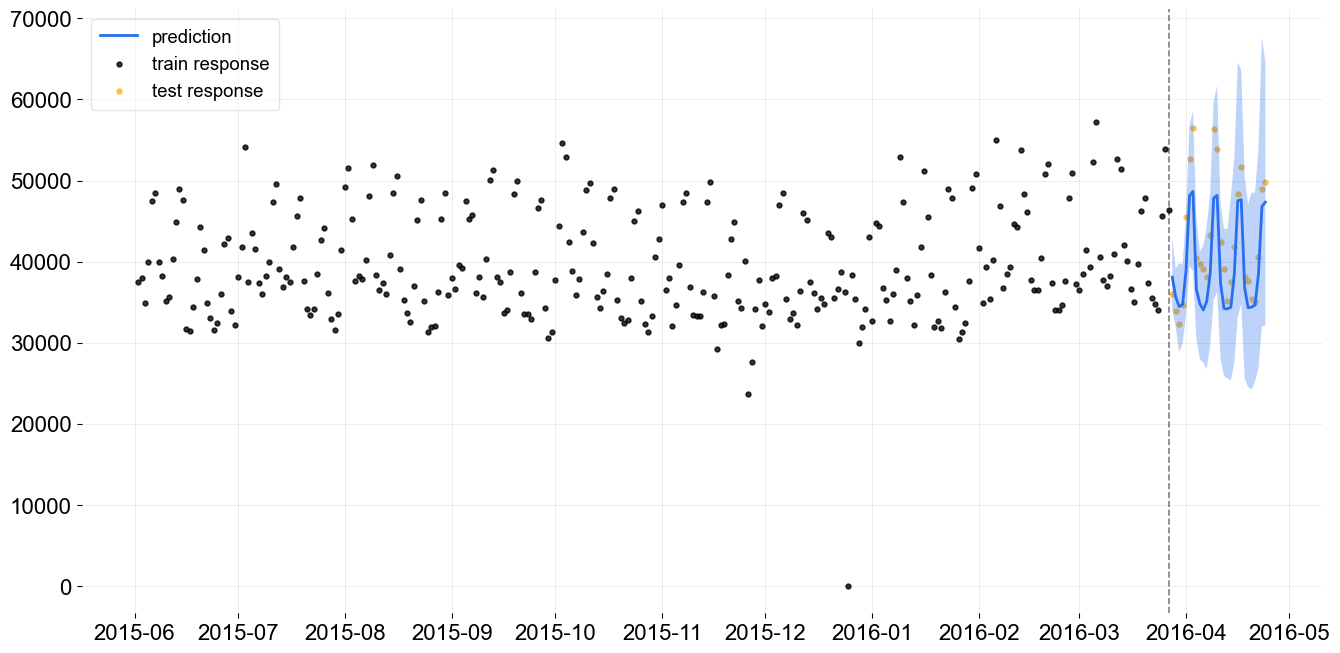

In [7]:
pred_df = dlt.predict(test_df)
# reverse transformation for prediction
pred_df[['prediction_5', 'prediction', 'prediction_95']] = \
  pred_df[['prediction_5', 'prediction', 'prediction_95']].apply(np.exp) * m
# plot last 300 observations from train only
plot_predicted_data(train_df[-300:], pred_df, 'date', 'sales', 'prediction', test_actual_df=test_df);

## Example II - Turkish Daily Electricity

Another example is the Turkish daily electricity demand data posted by Rob Hyndman. In this case, the seasonality is relatively smooth compared to the previous dataset.

In [8]:
# from 2000-01-01 to 2008-12-31
df = load_electricity_demand()
date_col = 'date'
response_col = 'electricity'

# trim data to speed up for demo
# df = df[df[date_col] >= '2005-01-01'].reset_index(drop=True)
# simple pre-process to anchor start at zero
m = df[response_col][0]
df[response_col] = np.log(df[response_col]/m)
print(df.shape)
df.head()

(3288, 2)


,date,electricity
0,2000-01-01,0.000000
1,2000-01-02,0.063700
2,2000-01-03,0.198053
3,2000-01-04,0.216324
4,2000-01-05,0.223295


In [9]:
df, fs_cols = make_fourier_series_df(df, 365.25, order=5)

In [10]:
test_size = 365
train_df = df[:-test_size]
test_df = df[-test_size:]

Note that due to the smoothness of the true seasonality (and with a long duration of a cycle), this hits the limit of **DLT** where it uses 1-step-ahead loss to guide the fitness. In breif, the smoothness nature of the seasonality  introduces some [degeneracy](https://en.wikipedia.org/wiki/Degeneracy_(mathematics)) issues where the model finds making a relatively memoryless trend can mimic a "good" 1-step ahead forecast.  

To resolve this issue, one can leverage the arg `forecast_horizon` to generate useful **Bayesian Information Criteria (BIC)** statistics to guide a better long-term forecast model. One can simply match the usage of the model with an appropriate value of `forecast_horizon`. For example, a `90` value is reasonable if we use it for quarterly forecast. The plan is to compute BIC on different setting of the smoothing parameters input by using args such as `level_sm_input`, `slope_sm_input` and `seasonality_sm_input`.

Another way to solve the problem is to leverage the hyper-parameters tuning function provided by the package (see the section discussing `Backtester` and `grid_search`).

First, users can propose a few choices as a grid.

In [11]:
param_grid = {
    'level_sm_input': np.exp(np.linspace(-5, -2, 4)),
    'slope_sm_input': np.exp(np.linspace(-5, -2, 4)),
}

In [12]:
dlt = DLT(
    date_col=date_col,
    response_col=response_col,
    regressor_col=fs_cols,
    seed=2022,
    forecast_horizon=90,
    estimator='stan-map',
    verbose=False,
)

In [13]:
from orbit.utils.params_tuning import grid_search_orbit

In [14]:
best_params, tuned_df = grid_search_orbit(param_grid,
                                          model=dlt,
                                          df=train_df,
                                          n_splits=4,
                                          incremental_len=365,
                                          forecast_len=365,
                                          eval_method='bic',
                                          verbose=True)

  0%|          | 0/16 [00:00<?, ?it/s]INFO:orbit:tuning hyper-params {'level_sm_input': 0.006737946999085467, 'slope_sm_input': 0.006737946999085467}
INFO:orbit:tuning metric:-5.0761e+05
  6%|▋         | 1/16 [00:01<00:26,  1.78s/it]INFO:orbit:tuning hyper-params {'level_sm_input': 0.006737946999085467, 'slope_sm_input': 0.01831563888873418}
INFO:orbit:tuning metric:-5.0791e+05
 12%|█▎        | 2/16 [00:02<00:18,  1.31s/it]INFO:orbit:tuning hyper-params {'level_sm_input': 0.006737946999085467, 'slope_sm_input': 0.049787068367863944}
INFO:orbit:tuning metric:-5.086e+05
 19%|█▉        | 3/16 [00:04<00:17,  1.38s/it]INFO:orbit:tuning hyper-params {'level_sm_input': 0.006737946999085467, 'slope_sm_input': 0.1353352832366127}
INFO:orbit:tuning metric:-5.099e+05
 25%|██▌       | 4/16 [00:05<00:16,  1.34s/it]INFO:orbit:tuning hyper-params {'level_sm_input': 0.01831563888873418, 'slope_sm_input': 0.006737946999085467}
INFO:orbit:tuning metric:-5.1169e+05
 31%|███▏      | 5/16 [00:07<00:16,  1.

In [15]:
tuned_df.head()

,level_sm_input,slope_sm_input,metrics
0,0.006738,0.006738,-507612.711938
1,0.006738,0.018316,-507905.256133
2,0.006738,0.049787,-508597.160814
3,0.006738,0.135335,-509900.493583
4,0.018316,0.006738,-511692.153128


In [16]:
best_params

[{'level_sm_input': 0.01831563888873418,
  'slope_sm_input': 0.006737946999085467}]

Refit the model with the best (lowest) leave-future out BIC. This time the model is fitted by MCMC to fully inform the uncertainties.

In [17]:
%%time
dlt = DLT(
    date_col=date_col,
    response_col=response_col,
    regressor_col=fs_cols,
    seasonality=7,
    seed=2022,
    estimator='stan-mcmc',
    **best_params[0],
    num_warmup=500,
    num_sample=500,
)
dlt.fit(train_df);

INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 125 and samples(per chain): 125.
To run all diagnostics call pystan.check_hmc_diagnostics(fit)


CPU times: user 954 ms, sys: 545 ms, total: 1.5 s
Wall time: 7min 33s


predict and plot the result.

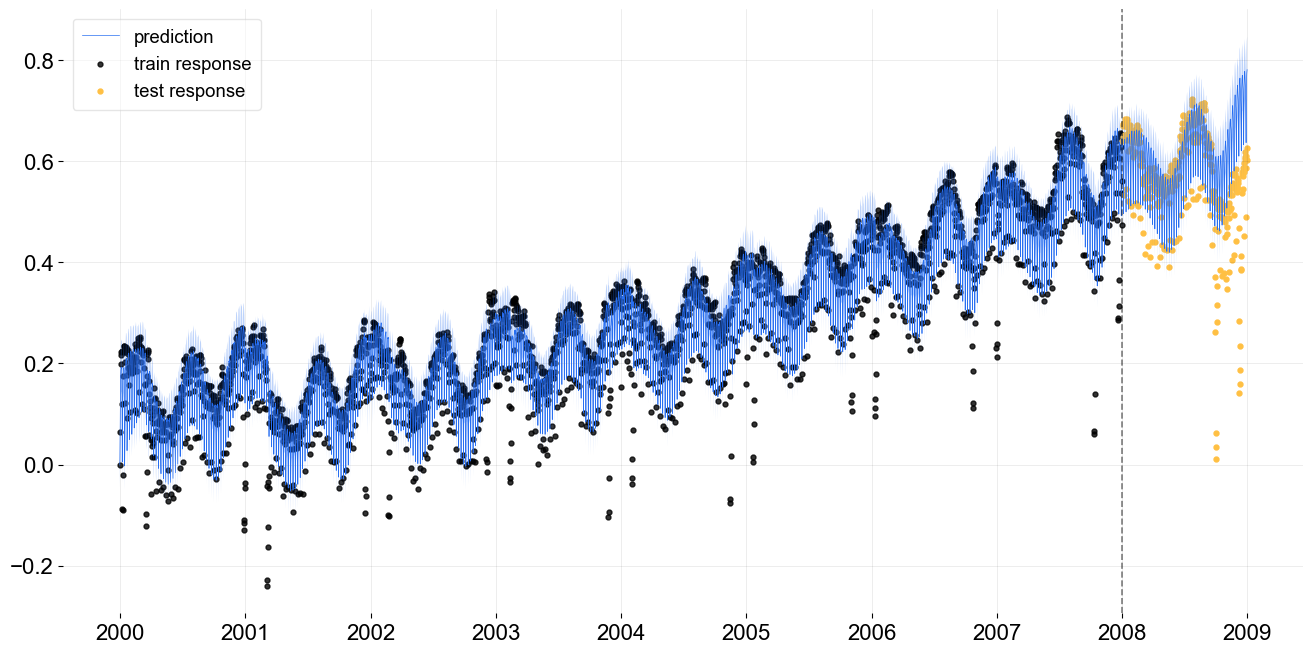

In [18]:
pred_df = dlt.predict(df)
plot_predicted_data(train_df, pred_df, 'date', 'electricity', 'prediction', test_actual_df=test_df, lw=0.5);

## Conclusion

In this article, we provide a work around solution to use **DLT** to model data with complex seasonality. One can combine the usage of hyper-parameters tuning to further optimize the smoothing parameters by either backtest or the leave-future-out BICs.  Alternatively, users can consider solution such as **dynamic harmonic regression** or the **KTR(check out other tuturial section in Orbit for details)**.

## References

1. Young, P. C., Pedregal, D. J., & Tych, W. (1999). Dynamic harmonic regression. Journal of Forecasting, 18, 369–394.\[[DOI](https://doi.org/10.1002/(SICI)1099-131X(199911)18:6%3C369::AID-FOR748%3E3.0.CO;2-K)\]